In [1]:
import pandas as pd

df = pd.read_csv('D:\Tugas Akhir\Codingan\Development\Data\preprocessed_data_train.csv')
df.head()

c:\Users\Jesselyn Mu\anaconda3\envs\myenv\lib\site-packages\numpy\__init__.py:148: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "c:\Users\Jesselyn Mu\anaconda3\envs\myenv\python.exe"
  * The NumPy version is: "1.21.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


In [2]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['resign_date'] = pd.to_datetime(df['resign_date'])

min_join_date = df['join_date'].min()
max_join_date = df['join_date'].max()

min_resign_date = df['resign_date'].min()
max_resign_date = df['resign_date'].max()

print("Join Date - Min:", min_join_date)
print("Join Date - Max:", max_join_date)
print("Resign Date - Min:", min_resign_date)
print("Resign Date - Max:", max_resign_date)

Join Date - Min: 2020-01-02 00:00:00
Join Date - Max: 2024-10-30 00:00:00
Resign Date - Min: 2020-05-05 00:00:00
Resign Date - Max: 2024-10-31 00:00:00


In [32]:
df = df.dropna(subset=['marriage_stat'])

In [3]:
# from sklearn.model_selection import train_test_split

# cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
#                'education', 'active_work_category', 'resign_risk_indicator', 'jenis_kelamin']

X = df.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y = df['active_work_months']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df['join_date'] = pd.to_datetime(df['join_date'])

train_data = df[df['join_date'] < '2023-01-01']
valid_data = df[df['join_date'] >= '2023-01-01']

X_train = train_data.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y_train = train_data['active_work_months']

X_valid = valid_data.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y_valid = valid_data['active_work_months']

cat_feature = ['departemen', 'position', 'domisili', 'marriage_stat', 'job_satisfaction', 'performance_rating',
               'education', 'active_work_category', 'resign_risk_indicator', 'jenis_kelamin']

In [4]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    cat_features=cat_feature,
    loss_function='RMSE',  # Fungsi kerugian regresi, seperti RMSE atau MAE
    eval_metric='RMSE',    # Metrik evaluasi regresi
    verbose=200
)

model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

0:	learn: 13.5633497	test: 22.5835323	best: 22.5835323 (0)	total: 258ms	remaining: 4m 17s
200:	learn: 2.2131170	test: 4.9022408	best: 4.9022408 (200)	total: 8.86s	remaining: 35.2s
400:	learn: 0.5838665	test: 2.2138070	best: 2.2138070 (400)	total: 17.6s	remaining: 26.2s
600:	learn: 0.3577892	test: 1.7168738	best: 1.7168738 (600)	total: 26.6s	remaining: 17.7s
800:	learn: 0.3073068	test: 1.5536284	best: 1.5536284 (800)	total: 35.5s	remaining: 8.82s
999:	learn: 0.2891487	test: 1.4757698	best: 1.4757678 (998)	total: 44.5s	remaining: 0us

bestTest = 1.475767819
bestIteration = 998

Shrink model to first 999 iterations.


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi pada data valid
y_pred = model.predict(X_valid)

# Menghitung metrik regresi
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

# Membuat dataframe hasil metrik
metrics = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "R2 Score": r2
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df

,Score
MSE,2.177891
MAE,0.834776
RMSE,1.475768
R2 Score,0.930862


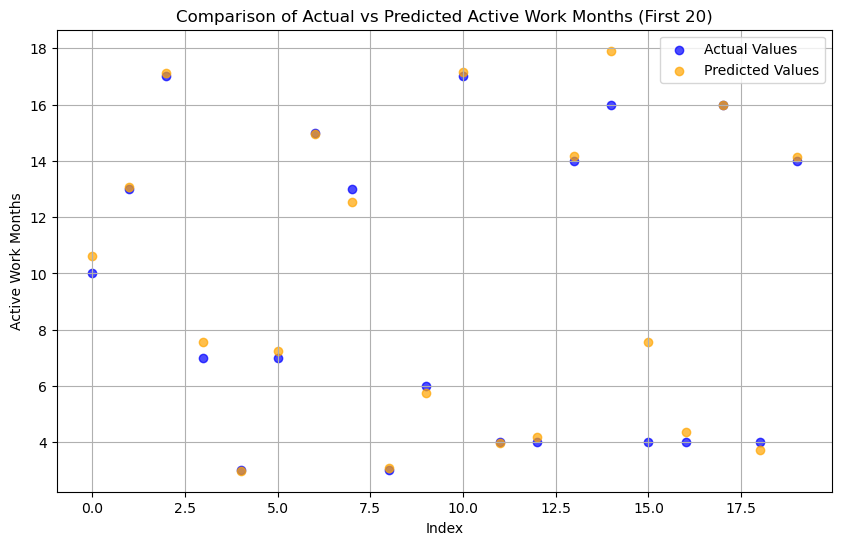

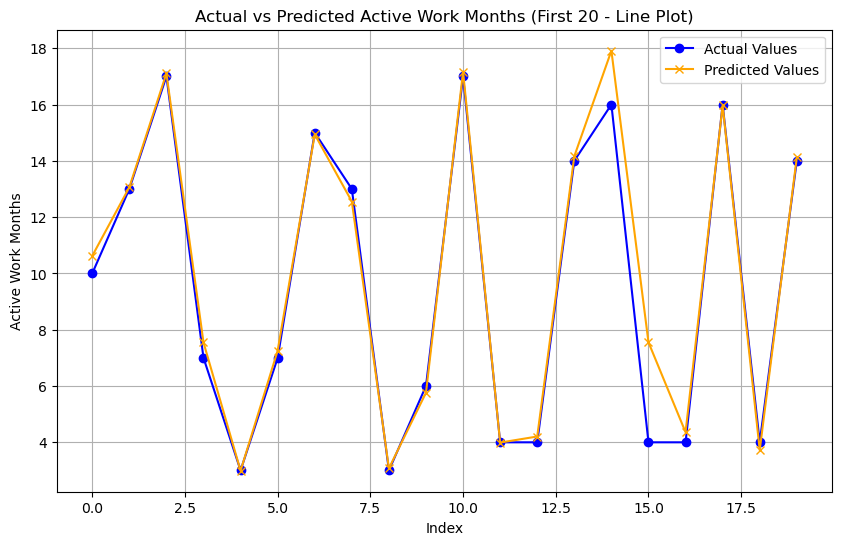

In [7]:
import matplotlib.pyplot as plt

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})

# Membatasi hanya pada 20 indeks pertama
comparison_df_subset = comparison_df.iloc[:20]

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months (First 20)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (First 20 - Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Fungsi objective untuk Optuna
def objective(trial):
    # Definisikan parameter yang akan dioptimasi
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 6),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 20),
        'random_strength': trial.suggest_float('random_strength', 5, 10),
        'cat_features': cat_feature,
        'loss_function': 'RMSE',  # Fungsi kerugian untuk regresi
        'random_state': 42,
        'verbose': 0
    }

    # Inisialisasi model dengan parameter yang dioptimasi
    model = CatBoostRegressor(**params)

    # Melatih model dengan validasi
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    # Prediksi nilai target
    y_pred = model.predict(X_valid)

    # Hitung RMSE
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse  # Mengembalikan RMSE sebagai skor yang ingin diminimalkan

# Membuat studi Optuna
study = optuna.create_study(direction="minimize")  # Minimalkan RMSE
study.optimize(objective, n_trials=20)

# Menampilkan hasil terbaik
print("Best trial:")
print(f"  RMSE: {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2025-01-15 20:13:29,609] A new study created in memory with name: no-name-08bf7bda-2a69-4819-aee4-c38c972943cd
[I 2025-01-15 20:14:05,596] Trial 0 finished with value: 2.7842129590357327 and parameters: {'iterations': 947, 'learning_rate': 0.021474274017260056, 'depth': 6, 'subsample': 0.6597772630375474, 'colsample_bylevel': 0.6725654633870543, 'l2_leaf_reg': 11.904064563391351, 'random_strength': 6.636852794260673}. Best is trial 0 with value: 2.7842129590357327.
[I 2025-01-15 20:14:18,537] Trial 1 finished with value: 3.3604966459792873 and parameters: {'iterations': 532, 'learning_rate': 0.014997699392015939, 'depth': 4, 'subsample': 0.5066064744995207, 'colsample_bylevel': 0.6769577723016567, 'l2_leaf_reg': 18.54766425803946, 'random_strength': 7.313362982904383}. Best is trial 0 with value: 2.7842129590357327.
[I 2025-01-15 20:14:35,244] Trial 2 finished with value: 10.731547937509777 and parameters: {'iterations': 745, 'learning_rate': 0.0018382281881892761, 'depth': 4, 'subs

Best trial:
  RMSE: 1.70690993706933
  Params: {'iterations': 567, 'learning_rate': 0.03781343917057186, 'depth': 4, 'subsample': 0.6039387723621907, 'colsample_bylevel': 0.6808598591491113, 'l2_leaf_reg': 11.477573214087545, 'random_strength': 9.74704206793275}


In [10]:
from sklearn.metrics import mean_squared_error

# Ambil parameter terbaik dari Optuna
best_params = study.best_trial.params

# Tambahkan parameter tetap (yang tidak dioptimasi)
best_params.update({
    'loss_function': 'RMSE',  # Gunakan RMSE sebagai loss function
    'cat_features': cat_feature,
    'random_state': 42,
    'verbose': 200,  # Aktifkan output verbose
    'od_type': 'Iter',
    'od_wait': 50
})

# Latih model dengan parameter terbaik
final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Evaluasi model final
y_pred = final_model.predict(X_valid)
final_rmse = mean_squared_error(y_valid, y_pred, squared=False)  # Hitung RMSE
print(f"Final RMSE: {final_rmse}")

0:	learn: 13.3189474	test: 22.4201913	best: 22.4201913 (0)	total: 30.4ms	remaining: 17.2s
200:	learn: 1.3383498	test: 3.1531773	best: 3.1531773 (200)	total: 4.53s	remaining: 8.25s
400:	learn: 0.5436172	test: 1.9572286	best: 1.9572286 (400)	total: 9.49s	remaining: 3.93s
566:	learn: 0.4106783	test: 1.7069099	best: 1.7069099 (566)	total: 13.6s	remaining: 0us

bestTest = 1.706909937
bestIteration = 566

Final RMSE: 1.70690993706933


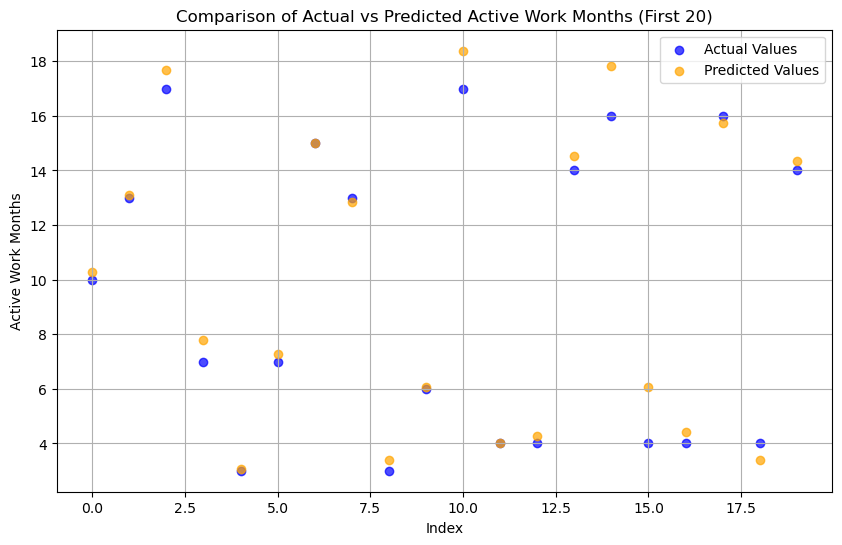

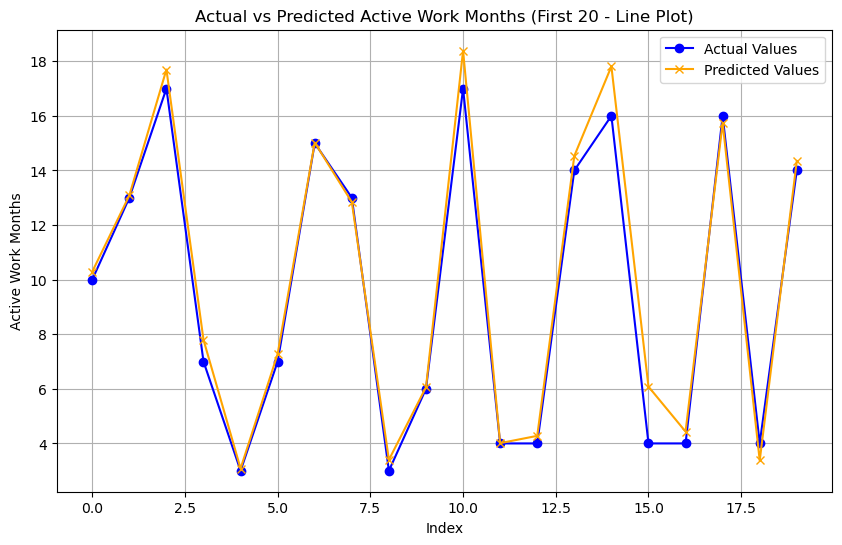

In [11]:
import matplotlib.pyplot as plt

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})

# Membatasi hanya pada 20 indeks pertama
comparison_df_subset = comparison_df.iloc[:20]

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months (First 20)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Actual'], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(comparison_df_subset)), comparison_df_subset['Predicted'], label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (First 20 - Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

Final Training RMSE: 0.2891486734682186
Final Validation RMSE: 1.4757698154285221


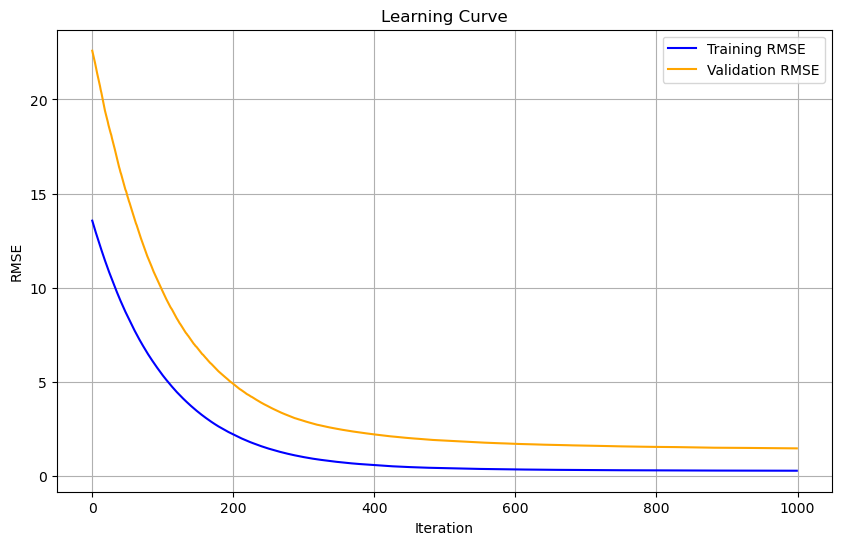

In [13]:
# Ambil hasil evaluasi dari model
evals_result = model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['RMSE'][-1]
val_score = evals_result['validation']['RMSE'][-1]

print(f"Final Training RMSE: {train_score}")
print(f"Final Validation RMSE: {val_score}")

# Import library untuk visualisasi
import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

Final Training RMSE: 0.4106782777280611
Final Validation RMSE: 1.706909937069329


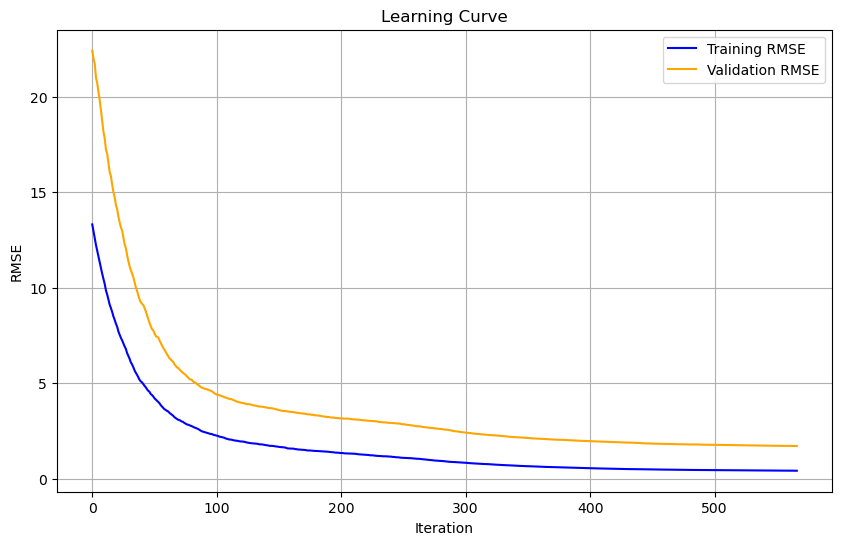

In [12]:
# Ambil hasil evaluasi dari model
evals_result = final_model.get_evals_result()

# Menampilkan skor terakhir
train_score = evals_result['learn']['RMSE'][-1]
val_score = evals_result['validation']['RMSE'][-1]

print(f"Final Training RMSE: {train_score}")
print(f"Final Validation RMSE: {val_score}")

# Import library untuk visualisasi
import matplotlib.pyplot as plt

# Ambil skor training dan validation dari evals_result
train_rmse = evals_result['learn']['RMSE']
val_rmse = evals_result['validation']['RMSE']

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Training RMSE', color='blue')
plt.plot(val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prediksi pada data valid
y_pred = final_model.predict(X_valid)

# Menghitung metrik regresi
mse = mean_squared_error(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

# Membuat dataframe hasil metrik
metrics = {
    "MSE": mse,
    "MAE": mae,
    "RMSE": rmse,
    "R2 Score": r2
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df

,Score
MSE,2.913542
MAE,0.893629
RMSE,1.706910
R2 Score,0.907509


In [44]:
import pickle

with open('regression_model.sav', 'wb') as f:
    pickle.dump(model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [15]:
import pickle

with open('regression_model_final.sav', 'wb') as f:
    pickle.dump(final_model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [40]:
# Mengurutkan data berdasarkan waktu (join_date)
df = df.sort_values('join_date')
X = df.drop(columns=['active_work_months', 'churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])
y = df['active_work_months']

0:	learn: 9.1927263	total: 27.2ms	remaining: 27.2s
200:	learn: 1.8023540	total: 5.96s	remaining: 23.7s
400:	learn: 0.6209110	total: 15.7s	remaining: 23.5s
600:	learn: 0.4269301	total: 27.9s	remaining: 18.5s
800:	learn: 0.3636209	total: 34.1s	remaining: 8.46s
999:	learn: 0.3239213	total: 45.2s	remaining: 0us
0:	learn: 10.1498267	total: 54.1ms	remaining: 54.1s
200:	learn: 1.8413201	total: 12.1s	remaining: 48.1s
400:	learn: 0.5739607	total: 18.5s	remaining: 27.6s
600:	learn: 0.3855343	total: 28.4s	remaining: 18.8s
800:	learn: 0.3321234	total: 40.9s	remaining: 10.2s
999:	learn: 0.3056851	total: 47.8s	remaining: 0us
0:	learn: 12.0823549	total: 31ms	remaining: 31s
200:	learn: 2.0424293	total: 16.1s	remaining: 1m 4s
400:	learn: 0.5614638	total: 27.2s	remaining: 40.7s
600:	learn: 0.3540443	total: 37.5s	remaining: 24.9s
800:	learn: 0.3048528	total: 53s	remaining: 13.2s
999:	learn: 0.2854924	total: 1m 3s	remaining: 0us
0:	learn: 13.6327729	total: 32.6ms	remaining: 32.6s
200:	learn: 2.2277348	tot

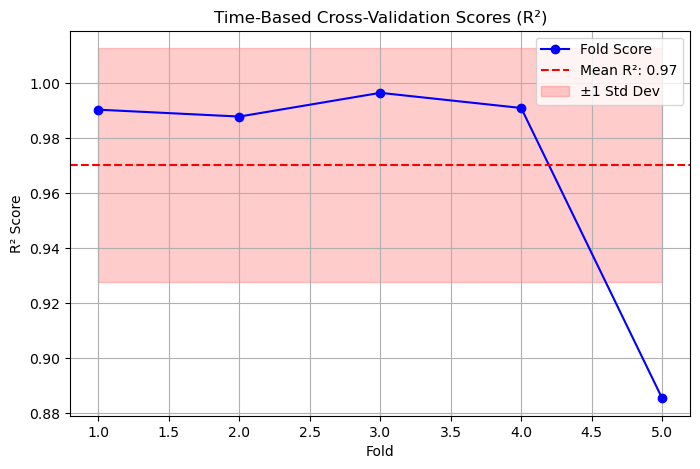

R² Scores for each fold: [0.99040942 0.98790673 0.99653286 0.99102248 0.88548406]
Mean R²: 0.97
Standard Deviation: 0.04


In [41]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk menghitung skor cross-validation dengan TimeSeriesSplit
def time_series_cross_validate_and_visualize_r2(model, X, y, n_splits=5):
    # TimeSeriesSplit untuk data terkait waktu
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Hitung skor cross-validation dengan metrik R²
    scores = cross_val_score(model, X, y, scoring='r2', cv=tscv)

    # Rata-rata dan standar deviasi
    mean_score = np.mean(scores)
    std_score = np.std(scores)

    # Visualisasi hasil cross-validation
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, n_splits + 1), scores, marker='o', linestyle='-', color='b', label='Fold Score')
    plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean R²: {mean_score:.2f}')
    plt.fill_between(range(1, n_splits + 1), mean_score - std_score, mean_score + std_score, color='r', alpha=0.2, label='±1 Std Dev')
    plt.title('Time-Based Cross-Validation Scores (R²)')
    plt.xlabel('Fold')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid()
    plt.show()

    # Cetak hasil skor
    print(f'R² Scores for each fold: {scores}')
    print(f'Mean R²: {mean_score:.2f}')
    print(f'Standard Deviation: {std_score:.2f}')

# Contoh penggunaan
time_series_cross_validate_and_visualize_r2(model, X, y, n_splits=5)

0:	learn: 8.7841225	total: 17.9ms	remaining: 12.3s
200:	learn: 0.6414325	total: 4.79s	remaining: 11.6s
400:	learn: 0.4070658	total: 9.53s	remaining: 6.82s
600:	learn: 0.3136415	total: 14.6s	remaining: 2.11s
687:	learn: 0.2871957	total: 18.3s	remaining: 0us
0:	learn: 9.6341897	total: 38.6ms	remaining: 26.5s
200:	learn: 0.5292219	total: 8.49s	remaining: 20.6s
400:	learn: 0.3513814	total: 16.8s	remaining: 12s
600:	learn: 0.2840241	total: 21.7s	remaining: 3.13s
687:	learn: 0.2635121	total: 24.4s	remaining: 0us
0:	learn: 11.3736677	total: 29.5ms	remaining: 20.3s
200:	learn: 0.5146587	total: 5.86s	remaining: 14.2s
400:	learn: 0.3822767	total: 10.9s	remaining: 7.81s
600:	learn: 0.3077429	total: 16.1s	remaining: 2.33s
687:	learn: 0.2894420	total: 18.5s	remaining: 0us
0:	learn: 12.7272643	total: 26.4ms	remaining: 18.1s
200:	learn: 0.5280327	total: 6.21s	remaining: 15s
400:	learn: 0.3907724	total: 13.1s	remaining: 9.38s
600:	learn: 0.3223581	total: 22.6s	remaining: 3.27s
687:	learn: 0.3042779	to

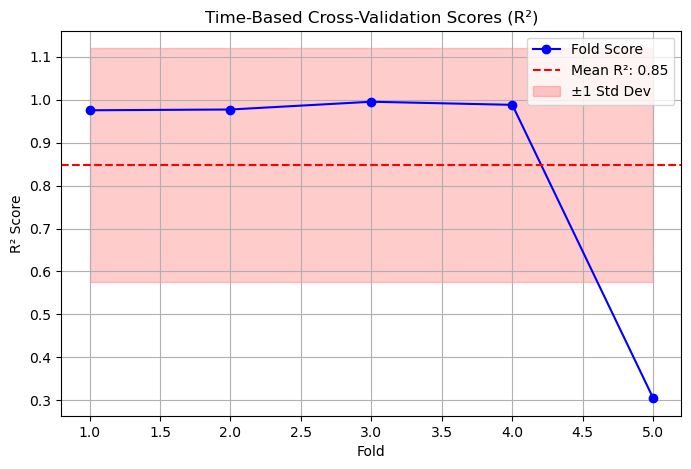

R² Scores for each fold: [0.97547565 0.97730142 0.99540966 0.98816158 0.30451961]
Mean R²: 0.85
Standard Deviation: 0.27


In [43]:
time_series_cross_validate_and_visualize_r2(final_model, X, y, n_splits=5)

# Testing

In [45]:
df_test = pd.read_csv('D:\Tugas Akhir\Codingan\Development\Data\data_testing.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM9660,Kota Jakarta Timur,Perempuan,1970-07-27,2023-10-09,2024-10-31,Single,0,D3,2.0,...,Mid-term,4.000000,1,1,4843236.0,4,1210809.00,2.0,Medium,9.182979
1,EM12614,Tangerang,Laki-laki,1972-03-13,2023-12-19,2024-10-31,Married,1,D1,1.0,...,Short-term,5.000000,2,1,3491432.0,2,1745716.00,2.6,Medium,9.529412
2,EM2150,Kota Jakarta Timur,Laki-laki,1986-12-27,2022-05-22,2023-07-05,Married,1,SLTA,4.0,...,Mid-term,2.600000,2,1,1727468.0,1,1727468.00,3.0,Medium,9.288164
3,EM6733,Kabupaten Bogor,Laki-laki,1978-07-12,2022-12-07,2024-10-31,Married,4,D3,6.0,...,Mid-term,3.285714,5,1,3745375.0,4,936343.75,1.6,Medium,9.053694
4,EM9133,Kabupaten Bekasi,Perempuan,1994-06-03,2023-05-29,2023-10-20,Married,0,SLTA,0.0,...,Short-term,4.000000,1,1,2658503.0,1,2658503.00,1.0,Medium,9.540000


In [46]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = final_model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9951390052323061
Mean Absolute Error (MAE): 0.44852516212478744
Mean Squared Error (MSE): 1.198342479918863
Root Mean Squared Error (RMSE): 1.094688302631787


In [47]:
df_test = pd.read_csv('D:\Tugas Akhir\Codingan\Development\Data\data_testing_resign.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM13260,Kota Jakarta Barat,Perempuan,1976-12-02,2020-10-25,2023-02-16,Married,2,SLTA,8.0,...,Mid-term,3.111111,3,1,2252793.0,1,2.252793e+06,2.0,Medium,9.280456
1,EM0533,Tangerang,Laki-laki,1970-10-08,2022-10-05,2024-03-25,Married,3,SLTA,14.0,...,Mid-term,1.133333,4,1,1784520.0,1,1.784520e+06,1.8,Medium,9.809471
2,EM7296,Kota Depok,Perempuan,1980-05-10,2022-07-21,2023-09-01,Married,2,SLTA,14.0,...,Mid-term,0.866667,3,1,1291410.0,1,1.291410e+06,1.6,Medium,9.534629
3,EM9032,Kota Depok,Perempuan,1993-10-24,2022-07-05,2024-01-25,Married,2,D2,7.0,...,Mid-term,2.250000,3,1,3909283.0,3,1.303094e+06,1.0,Medium,9.468933
4,EM11615,Tangerang,Laki-laki,1987-02-02,2022-09-14,2023-11-03,Divorce,0,SLTA,8.0,...,Mid-term,1.444444,1,1,2615265.0,1,2.615265e+06,2.2,Medium,8.968309


In [48]:
# Memilih hanya kolom numerik
numerical_columns = df_test.select_dtypes(include=['int64', 'float64']).columns

# Filter: Hanya menyimpan baris yang tidak memiliki nilai negatif
df_test_filtered = df_test[(df_test[numerical_columns] >= 0).all(axis=1)]

# Menampilkan hasil
print("Jumlah baris sebelum filter:", df_test.shape[0])
print("Jumlah baris setelah filter:", df_test_filtered.shape[0])

Jumlah baris sebelum filter: 809
Jumlah baris setelah filter: 809


In [49]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = final_model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9982375650520496
Mean Absolute Error (MAE): 0.2113292077085458
Mean Squared Error (MSE): 0.08052087321650396
Root Mean Squared Error (RMSE): 0.2837620010087749


In [51]:
df_test = pd.read_csv('D:\Tugas Akhir\Codingan\Development\Data\data_testing_resign_6.csv')
df_test.head()

,employee_id,domisili,jenis_kelamin,date_of_birth,join_date,resign_date,marriage_stat,dependant,education,absent_90D,...,active_work_category,work_stability_score,married_dependent_ratio,position_score,job_income_position_score,education_score,education_income_ratio,weighted_satisfaction_performance,resign_risk_indicator,adjusted_work_time
0,EM0012,Tangerang,Laki-laki,1970-12-21,2023-02-23,2024-08-07,Married,3,D3,2.0,...,Mid-term,5.666667,4,1,4708861.0,4,1.177215e+06,1.4,Medium,9.857106
1,EM0026,Kota Depok,Laki-laki,1986-11-14,2022-04-17,2024-08-04,Married,2,SLTA,4.0,...,Mid-term,5.600000,3,1,1430853.0,1,1.430853e+06,1.0,Medium,9.694593
2,EM0041,Kota Jakarta Barat,Laki-laki,1983-03-16,2023-06-15,2024-09-06,Divorce,3,SLTA,7.0,...,Mid-term,1.750000,1,1,1379381.0,1,1.379381e+06,2.4,Medium,9.059429
3,EM0053,Kota Jakarta Timur,Laki-laki,1979-07-13,2023-07-11,2024-09-21,Single,0,SLTA,1.0,...,Mid-term,7.000000,1,1,1911583.0,1,1.911583e+06,1.0,Medium,9.842189
4,EM0057,Kota Jakarta Barat,Perempuan,2000-03-13,2022-07-14,2024-08-29,Single,0,D2,8.0,...,Mid-term,2.777778,1,1,3724157.0,3,1.241386e+06,2.0,Medium,9.047730


In [52]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Menghapus kolom yang tidak diperlukan untuk prediksi
X_test = df_test.drop(columns=['active_work_months','churn_status', 'employee_id', 'date_of_birth', 'join_date', 'resign_date'])

# Lakukan prediksi menggunakan model final
y_pred = final_model.predict(X_test)

# Tambahkan prediksi ke DataFrame
X_test['predicted_active_work'] = y_pred

# Hitung metrik evaluasi
r2 = r2_score(df_test['active_work_months'], y_pred)
mae = mean_absolute_error(df_test['active_work_months'], y_pred)
mse = mean_squared_error(df_test['active_work_months'], y_pred)
rmse = np.sqrt(mse)

# Cetak hasil
print("R² Score:", r2)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

R² Score: 0.9983869290912244
Mean Absolute Error (MAE): 0.18480799751480997
Mean Squared Error (MSE): 0.06445121600267545
Root Mean Squared Error (RMSE): 0.25387244041580304


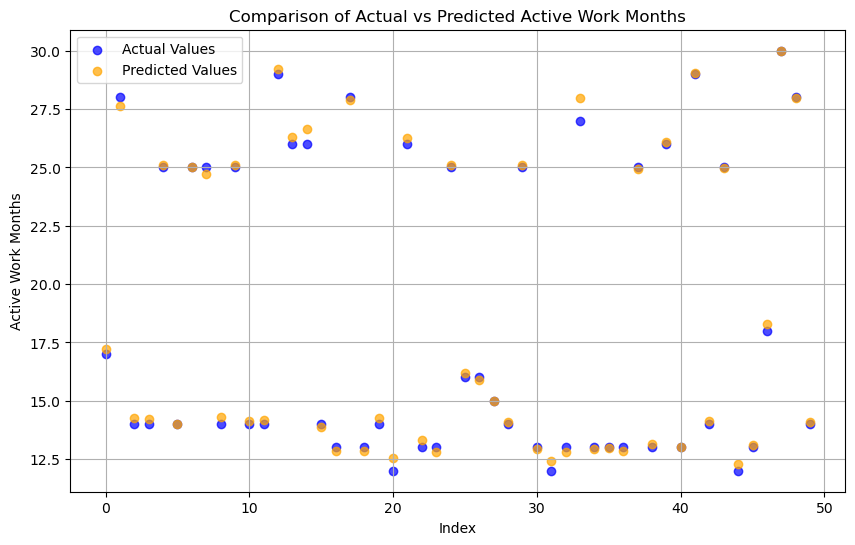

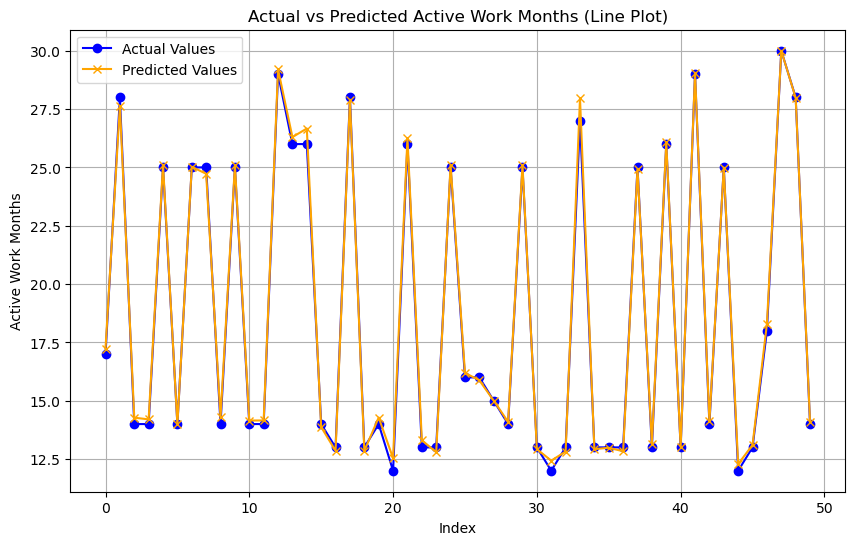

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# Nilai aktual dan prediksi
y_actual = df_test['active_work_months']  # Nilai aktual dari active_work_months
y_pred = X_test['predicted_active_work']  # Nilai prediksi dari model regresi

# Membuat DataFrame untuk mempermudah visualisasi
comparison_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})

# Scatter plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_actual)), y_actual, label='Actual Values', alpha=0.7, color='blue')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted Values', alpha=0.7, color='orange')
plt.title('Comparison of Actual vs Predicted Active Work Months')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

# Line plot untuk membandingkan prediksi dan nilai asli
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_actual)), y_actual, label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', marker='x', linestyle='-', color='orange')
plt.title('Actual vs Predicted Active Work Months (Line Plot)')
plt.xlabel('Index')
plt.ylabel('Active Work Months')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import pickle

with open('regression_model.sav', 'wb') as f:
    pickle.dump(final_model, f)
print("CatBoost Regression model saved to 'regression_model.sav'")

CatBoost Regression model saved to 'regression_model.sav'


In [1]:
%pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/02/48/033ab9a2dee26d3de7e57cf532ab1d8408a608544c85ff98e6ea65775bdf/shap-0.46.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
    --------------------------------------- 10.2/456.1 kB ? eta -:--:--
   --------- ------------------------------ 112.6/456.1 kB 1.6 MB/s eta 0:00:01
   ------------------------------------ --- 419.8/456.1 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
